
# **Signal Processing for Gait Symmetry Analysis**


# Loading Libraries

In [ ]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
from scipy.signal import find_peaks, butter, filtfilt
from scipy.interpolate import interp1d
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to apply a Butterworth lowpass filter
def butter_lowpass_filter(data, cutoff_frequency, sampling_rate, order=4):
    nyquist_frequency = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Loading Data

We have two dataset here, each corresponding to one type of walking. In each dataset, human-robot interaction during a period of walking has been recorded; Forward force, downward force and z-axis (forward direction) torque are present in the datasets.

## Inspecting .mat files


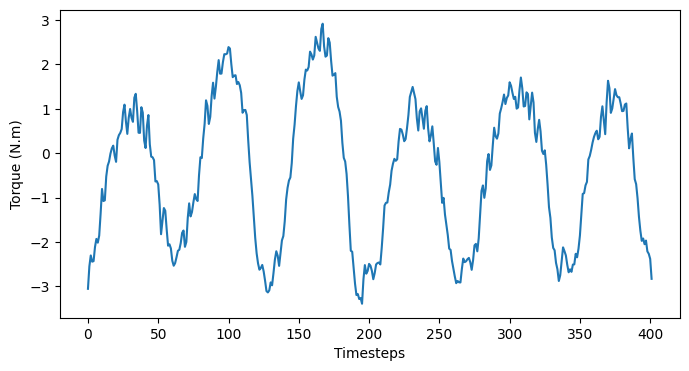

In [ ]:
fileName = "/content/Data_1" # Write the location of your file in your Google Drive
data = loadmat(fileName + ".mat")['to_be_saved'][2,3290:3692] #3290:3692

#Plotting the data
plt.figure(figsize=(8, 4))
plt.plot(data)
plt.xlabel('Timesteps')
plt.ylabel('Torque (N.m)')
plt.show()

In [ ]:
# Counting the number of steps (later, this is needed)
steps = 6

## Filtering the data

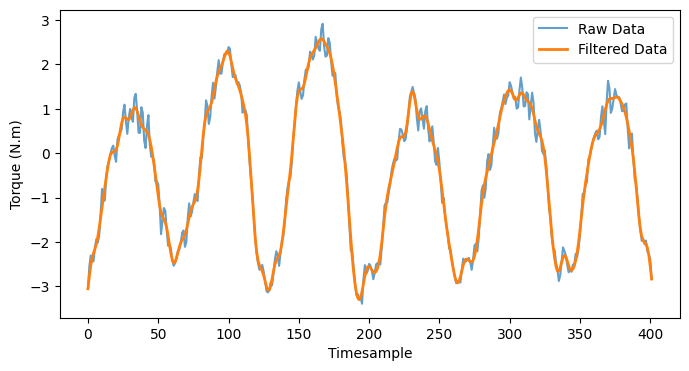

In [ ]:
# Set the cutoff frequency and sampling rate
cutoff_frequency = 5  # Adjust this based on your data characteristics
sampling_rate = 40  # Adjust this based on your data's sampling rate

# Apply the lowpass filter
filtered_data = butter_lowpass_filter(data, cutoff_frequency, sampling_rate)

# Plot the original and filtered data
plt.figure(figsize=(8, 4))
plt.plot(data, label='Raw Data', alpha=0.7)
plt.plot(filtered_data, label='Filtered Data', linewidth=2)
plt.xlabel('Timesample')
plt.ylabel('Torque (N.m)')
plt.legend()
plt.show()


## Splitting the strides

In order to apply the Seasonal-Trend Decomposition, each stride need to have the same length. So first, we find the starting and ending point of each stride, and then we can slice our data into strides.
To find the Valleys in our signal, we can flip the signal and find the peaks.

In [ ]:
lowest = -(filtered_data.max() - 0.2*(filtered_data.max()-filtered_data.min()))
lowest

-1.4042595316414512

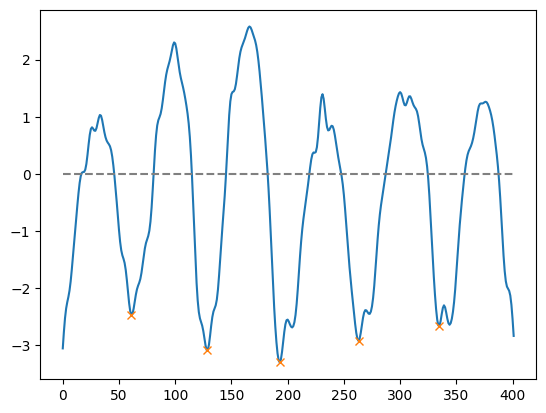

In [ ]:
peaks, _ = find_peaks(-filtered_data, height=lowest, distance=50)
plt.plot(filtered_data)
plt.plot(peaks, filtered_data[peaks], "x")
plt.plot(np.zeros_like(filtered_data), "--", color="gray")
plt.show()

In [ ]:
sliced_data = []
start_index = 0

for minima_index in peaks:
    sliced_data.append(filtered_data[start_index:minima_index + 1])
    start_index = minima_index + 1

# Include the last segment of the data
sliced_data.append(filtered_data[start_index:])
sliced_data = sliced_data[:]

Now that we have our data sliced, we can equalize the length of each stride. We chose the number 100, as it is higher than the length of each stride, and we'll also be able to express step duration as a percentage of the entire stride.

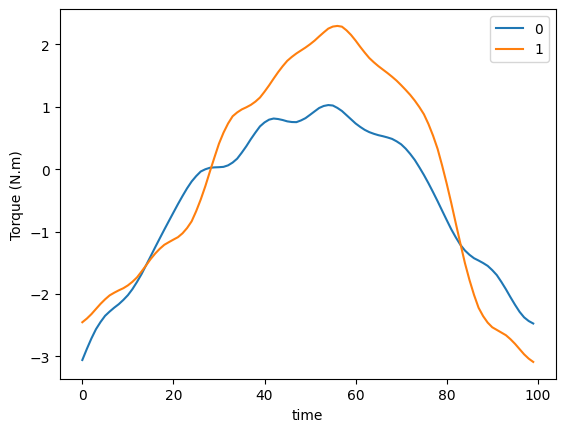

In [ ]:
max_length = 100
x_axis = np.linspace(0, 1, max_length)
interpolated_data = [interp1d(np.linspace(0, 1, len(lst)), lst, kind='linear')(x_axis) for lst in sliced_data]
plt.plot(interpolated_data[0], label='0')
plt.plot(interpolated_data[1], label='1')
plt.xlabel('time')
plt.ylabel('Torque (N.m)')
plt.legend()
plt.show()

In [ ]:
concatenated_list = []
for sublist in interpolated_data:
    concatenated_list.extend(sublist)

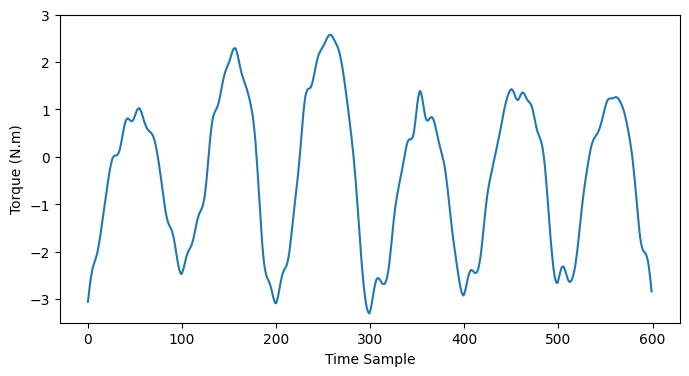

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(concatenated_list)
plt.xlabel('Time Sample')
plt.ylabel('Torque (N.m)')
plt.ylim(-3.5, 3)
plt.show()

# Multiple Seasonal-Trend decomposition

Here, we use the MSTL technique to separate the inherent periodicity from other sources of variability, including the changes in user speed and muscle fatigue.

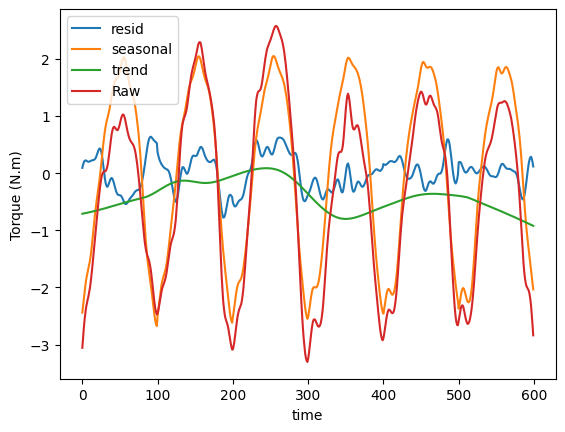

In [ ]:
res = MSTL(concatenated_list, periods=np.array(concatenated_list).shape[0]//steps).fit()

plt.plot(res.resid, label='resid')
plt.plot(res.seasonal, label='seasonal')
plt.plot(res.trend, label='trend')
plt.plot(concatenated_list, label='Raw')

plt.xlabel('time')
plt.ylabel('Torque (N.m)')
plt.legend()
plt.show()

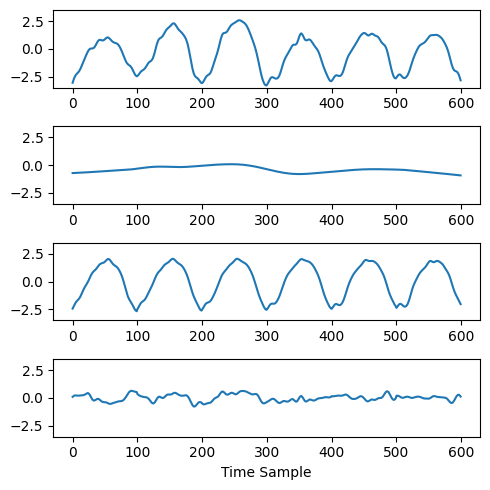

In [ ]:
plt.figure(figsize=(5, 5))

plt.subplot(4, 1, 1)
plt.plot(concatenated_list, label='Raw')
# plt.ylabel('Torque (N.m)')
plt.ylim(-3.5, 3.5)

plt.subplot(4, 1, 2)
plt.plot(res.trend, label='trend')
# plt.ylabel('Torque (N.m)')
plt.ylim(-3.5, 3.5)

plt.subplot(4, 1, 3)
plt.plot(res.seasonal, label='seasonal')
# plt.ylabel('Torque (N.m)')
plt.ylim(-3.5, 3.5)

plt.subplot(4, 1, 4)
plt.plot(res.resid, label='resid')
# plt.ylabel('Torque (N.m)')
plt.ylim(-3.5, 3.5)

plt.xlabel('Time Sample')
# plt.ylabel('Torque (N.m)')
plt.tight_layout()
plt.show()

## Splitting Strides for symmetry analysis

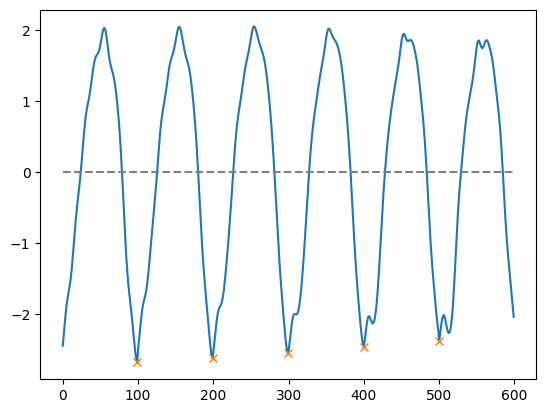

In [ ]:
peaks, _ = find_peaks(-res.seasonal, height=0.1,distance=50)
plt.plot(res.seasonal)
plt.plot(peaks, res.seasonal[peaks], "x")
plt.plot(np.zeros_like(res.seasonal), "--", color="gray")
plt.show()

In [ ]:
sliced_data = []
start_index = 0

for minima_index in peaks:
    sliced_data.append(res.seasonal[start_index:minima_index + 1]+res.trend[start_index:minima_index + 1])
    start_index = minima_index + 1

# Include the last segment of the data
sliced_data.append(res.seasonal[start_index:]+ res.trend[start_index:])
sliced_data = sliced_data[:]

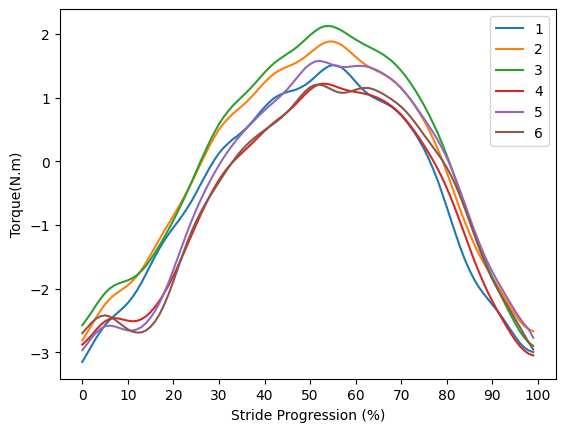

In [ ]:
max_length = 100
x_axis = np.linspace(0, 1, max_length)
interpolated_data = [interp1d(np.linspace(0, 1, len(lst)), lst, kind='linear')(x_axis) for lst in sliced_data]
plt.plot(interpolated_data[0], label='1')
plt.plot(interpolated_data[1], label='2')
plt.plot(interpolated_data[2], label='3')
plt.plot(interpolated_data[3], label='4')
plt.plot(interpolated_data[4], label='5')
plt.plot(interpolated_data[5], label='6')

plt.xlabel('Stride Progression (%)')
plt.ylabel('Torque(N.m)')
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.legend()
plt.show()

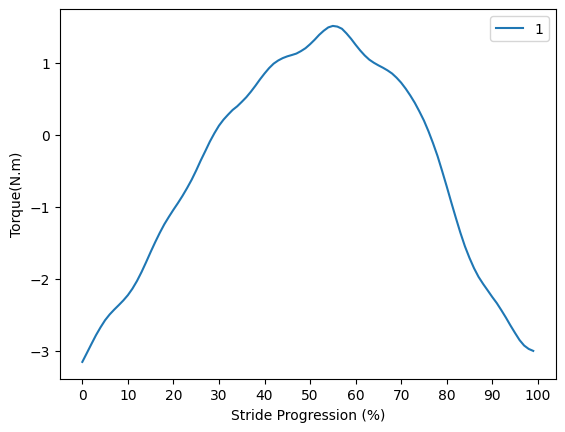

In [ ]:
max_length = 100
x_axis = np.linspace(0, 1, max_length)
interpolated_data = [interp1d(np.linspace(0, 1, len(lst)), lst, kind='linear')(x_axis) for lst in sliced_data]
plt.plot(interpolated_data[0], label='1')
plt.xlabel('Stride Progression (%)')
plt.ylabel('Torque(N.m)')
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.legend()
plt.show()

In [ ]:
np.argmax(interpolated_data[0])

55

# Second Dataset


## Loading the data

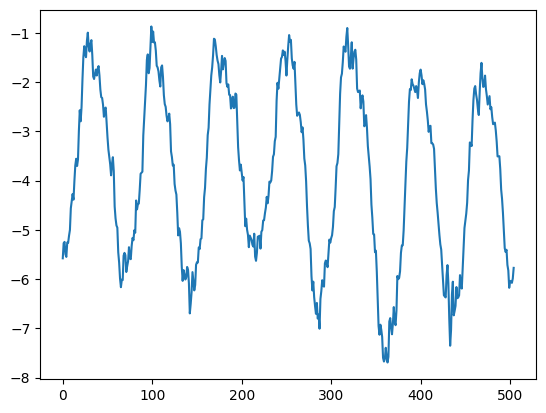

In [ ]:
fileName = "/content/Data_2"
data = loadmat(fileName + ".mat")['to_be_saved'][2,3970:4475]
plt.plot(data)
plt.show()


In [ ]:
steps = 7

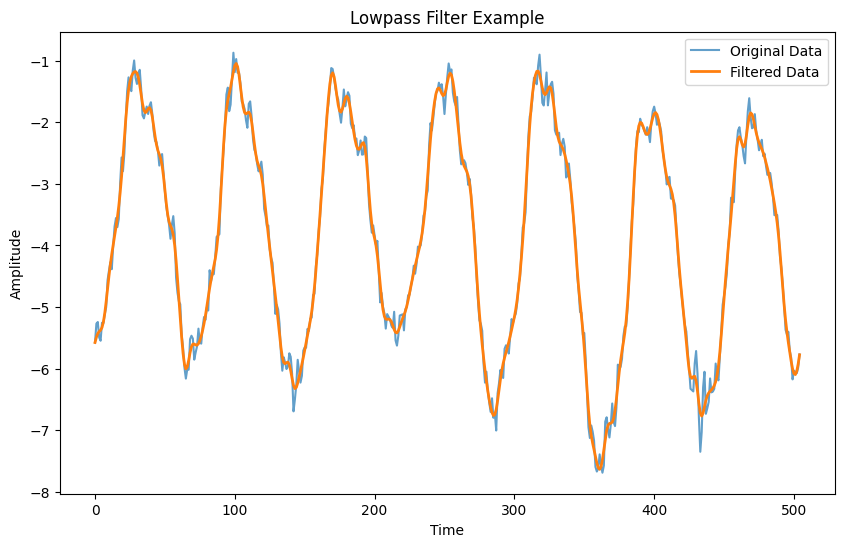

In [ ]:
# Set the cutoff frequency and sampling rate
cutoff_frequency = 5  # Adjust this based on your data characteristics
sampling_rate = 40  # Adjust this based on your data's sampling rate

# Apply the lowpass filter
filtered_data = butter_lowpass_filter(data, cutoff_frequency, sampling_rate)

# Plot the original and filtered data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data', alpha=0.7)
plt.plot(filtered_data, label='Filtered Data', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Lowpass Filter Example')
plt.legend()
plt.show()


In [ ]:
lowest = -(filtered_data.max() - 0.2*(filtered_data.max()-filtered_data.min()))
lowest

2.362458724537965

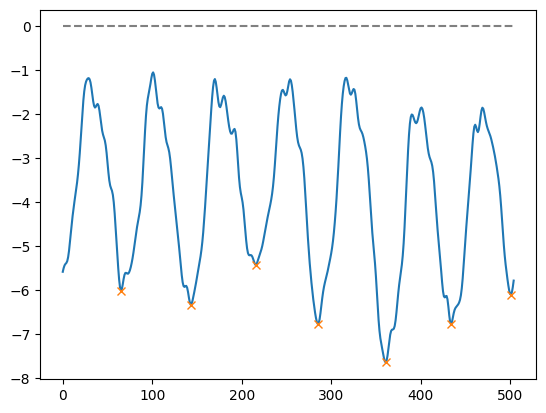

In [ ]:
peaks, _ = find_peaks(-filtered_data, height=lowest, distance=50)
plt.plot(filtered_data)
plt.plot(peaks, filtered_data[peaks], "x")
plt.plot(np.zeros_like(filtered_data), "--", color="gray")
plt.show()

In [ ]:
sliced_data = []
start_index = 0

for minima_index in peaks:
    sliced_data.append(filtered_data[start_index:minima_index + 1])
    start_index = minima_index + 1

# Include the last segment of the data
sliced_data.append(filtered_data[start_index:])
sliced_data = sliced_data[:-1]

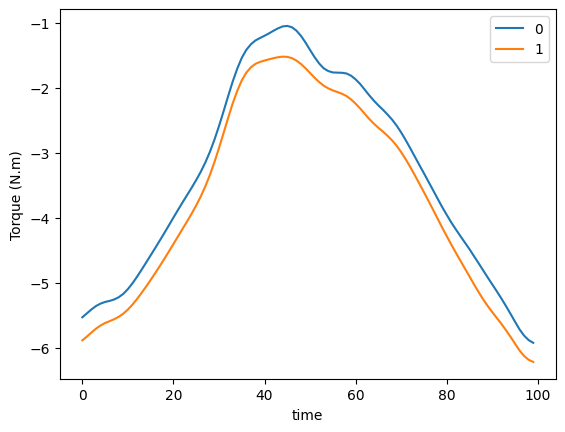

In [ ]:
max_length = 100
x_axis = np.linspace(0, 1, max_length)
interpolated_data = [interp1d(np.linspace(0, 1, len(lst)), lst, kind='linear')(x_axis) for lst in sliced_data]
plt.plot(interpolated_data[0], label='0')
plt.plot(interpolated_data[1], label='1')
plt.xlabel('time')
plt.ylabel('Torque (N.m)')
plt.legend()
plt.show()

In [ ]:
concatenated_list = []
for sublist in interpolated_data:
    concatenated_list.extend(sublist)

res = MSTL(concatenated_list,periods=np.array(concatenated_list).shape[0]//steps).fit()

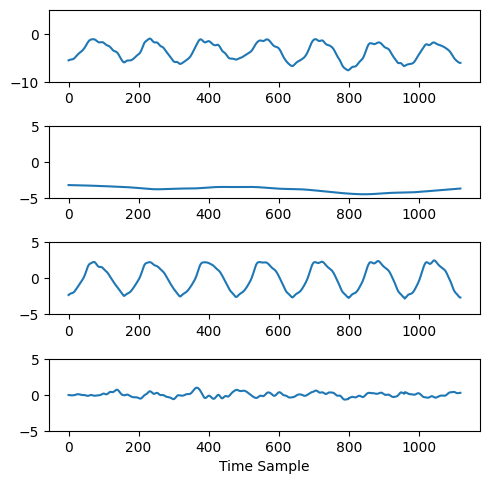

In [ ]:
plt.figure(figsize=(5, 5))

plt.subplot(4, 1, 1)
plt.plot(concatenated_list, label='Raw')
plt.ylim(-10, 5)

plt.subplot(4, 1, 2)
plt.plot(res.trend, label='trend')
plt.ylim(-5, 5)

plt.subplot(4, 1, 3)
plt.plot(res.seasonal, label='seasonal')
plt.ylim(-5, 5)

plt.subplot(4, 1, 4)
plt.plot(res.resid, label='resid')
plt.ylim(-5, 5)

plt.xlabel('Time Sample')
plt.tight_layout()
plt.show()

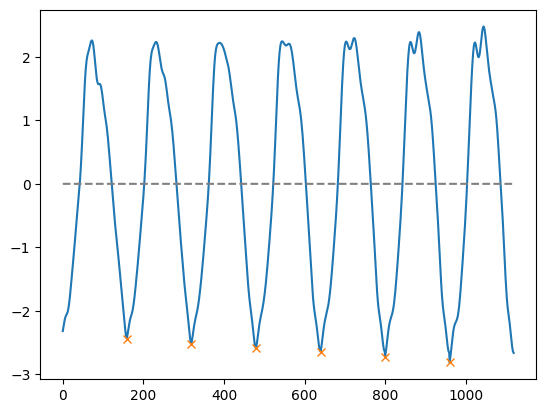

In [ ]:
peaks, _ = find_peaks(-res.seasonal, height=1.4,distance=30)
plt.plot(res.seasonal)
plt.plot(peaks, res.seasonal[peaks], "x")
plt.plot(np.zeros_like(res.seasonal), "--", color="gray")
plt.show()

In [ ]:
sliced_data = []
start_index = 0

for minima_index in peaks:
    sliced_data.append(res.seasonal[start_index:minima_index + 1]+res.trend[start_index:minima_index + 1])
    start_index = minima_index + 1

# Include the last segment of the data
sliced_data.append(res.seasonal[start_index:]+ res.trend[start_index:])
sliced_data = sliced_data[:]

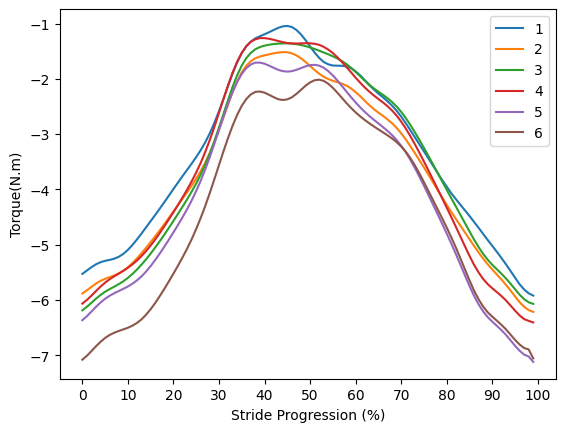

In [ ]:
max_length = 100
x_axis = np.linspace(0, 1, max_length)
interpolated_data = [interp1d(np.linspace(0, 1, len(lst)), lst, kind='linear')(x_axis) for lst in sliced_data]
plt.plot(interpolated_data[0], label='1')
plt.plot(interpolated_data[1], label='2')
plt.plot(interpolated_data[2], label='3')
plt.plot(interpolated_data[3], label='4')
plt.plot(interpolated_data[4], label='5')
plt.plot(interpolated_data[5], label='6')

plt.xlabel('Stride Progression (%)')
plt.ylabel('Torque(N.m)')
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.legend()
plt.show()

In [ ]:
np.argmax(interpolated_data[0])

45